# SL Homework 5
### b05705042 皇甫立翔

## Q1. [Baseline]

In [18]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor

dep2train = pd.read_csv('data/dep2train.csv')
dep2test = pd.read_csv('data/dep2test.csv')

In [19]:
train_week = [datetime.strptime(dep2train['date'][i],'%Y-%m-%d').strftime('%V') for i in range(len(dep2train))]
test_week = [datetime.strptime(dep2test['date'][i],'%Y-%m-%d').strftime('%V') for i in range(len(dep2test))]

In [20]:
err = []
dep2pred = []
for i in range(len(dep2test)):
    date_find = [test_week[i] == train_week[k] for k in range(len(train_week))]
    date_index = np.where(date_find)[0]
    date_index = list(date_index)
    e = (np.mean(dep2train['weeklySales'][date_index]) - dep2test['weeklySales'][i]) / dep2test['weeklySales'][i]
    dep2pred.append(np.mean(dep2train['weeklySales'][date_index]))
    err.append(np.abs(e))
print('MAPE = ', np.mean(err))

MAPE =  0.043591387170382884


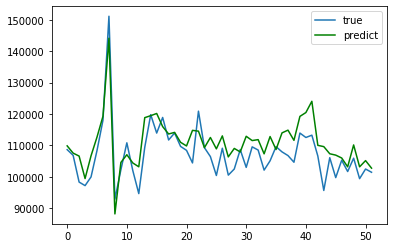

In [21]:
pltx = range(len(dep2pred))
plt.figure()
plt.plot(pltx, dep2test['weeklySales'], label='true')
plt.plot(pltx, dep2pred, c='green', label='predict')
plt.legend(loc='upper right')
plt.show()

## Q2. [Random Forest]

### Q2-1. 𝑦𝑡=𝑓(𝑦𝑡−1,𝑦𝑡−2,𝑦𝑡−3,𝑦𝑡−4)

In [22]:
rf_train = np.array(dep2train)
rf_test = np.array(dep2test)

In [23]:
rf_train_x = [rf_train.take(1, axis=1)[i:i+4] for i in range(len(rf_train)-4)]
rf_train_y = rf_train.take(1, axis=1)[4:]

In [24]:
rf_train_x = np.array(rf_train_x)

In [25]:
rfr = RandomForestRegressor(n_estimators=50, random_state=0, n_jobs=-1)
rfr.fit(rf_train_x, rf_train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [26]:
all_data = pd.concat([pd.DataFrame(rf_train), pd.DataFrame(rf_test)], axis=0)
all_data = np.array(all_data).take(1, axis=1)
rfr_predict_x = [all_data[i:i+4] for i in range(len(rf_train)-4, len(all_data)-4)]
rfr_predict_x = np.array(rfr_predict_x)

In [27]:
rfr_true_y = np.array(rf_test.take(1, axis=1))

In [28]:
rfr_predict_y = rfr.predict(rfr_predict_x)

In [29]:
rfr_err = np.mean(np.abs((rfr_predict_y - rfr_true_y) / rfr_true_y))
print('MAPE of random forest with previous 4 periods = ', rfr_err)

MAPE of random forest with previous 4 periods =  0.05558986715073641


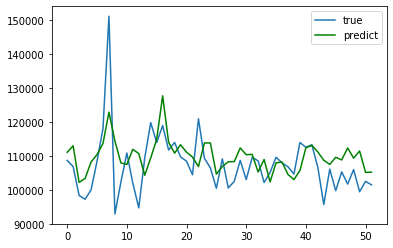

In [30]:
pltx = range(len(rfr_predict_y))
plt.figure()
plt.plot(pltx, rfr_true_y, label='true')
plt.plot(pltx, rfr_predict_y, c='green', label='predict')
plt.legend(loc='upper right')
plt.show()

### Q2-2. 𝑦𝑡=𝑓(𝑦𝑡−1,𝑦𝑡−2,𝑦𝑡−3,𝑦𝑡−4,𝑦𝑡−52)

In [31]:
rf_train_x2 = [np.append(rf_train.take(1, axis=1)[i], rf_train.take(1, axis=1)[i+48:i+52]) for i in range(len(rf_train)-52)]
rf_train_y2 = rf_train.take(1, axis=1)[52:]
rf_train_x2 = np.array(rf_train_x2)

In [32]:
rfr2 = RandomForestRegressor(n_estimators=200, random_state=0, n_jobs=-1)
rfr2.fit(rf_train_x2, rf_train_y2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [33]:
all_data2 = pd.concat([pd.DataFrame(rf_train), pd.DataFrame(rf_test)], axis=0)
all_data2 = np.array(all_data2).take(1, axis=1)
rfr_predict_x2 = [np.append(all_data2[i], all_data2[i+48:i+52]) for i in range(len(rf_train)-52, len(all_data2)-52)]
rfr_predict_x2 = np.array(rfr_predict_x2)

In [34]:
rfr_predict_y2 = rfr2.predict(rfr_predict_x2)

In [35]:
rfr_err2 = np.mean(np.abs((rfr_predict_y2 - rfr_true_y) / rfr_true_y))
print('MAPE of random forest with additional same period in last year = ', rfr_err2)

MAPE of random forest with additional same period in last year =  0.0373317792035271


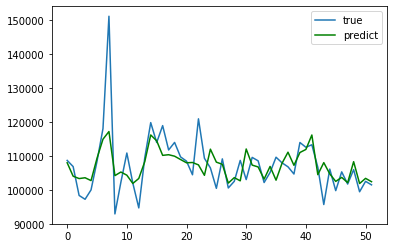

In [36]:
pltx = range(len(rfr_predict_y2))
plt.figure()
plt.plot(pltx, rfr_true_y, label='true')
plt.plot(pltx, rfr_predict_y2, c='green', label='predict')
plt.legend(loc='upper right')
plt.show()

## Q3. [Gaussian process regression]

In [37]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel
sum_kernel = RBF() + ExpSineSquared() + WhiteKernel()

### Q3-1.

In [38]:
gpr_train_x = np.array([int(i) for i in train_week])
gpr_train_sales = rf_train.take(1, axis=1)

gpr_train_y = (gpr_train_sales - np.mean(gpr_train_sales)) / np.std(gpr_train_sales)

In [39]:
gpr_train_x = gpr_train_x.reshape(-1, 1)
gpr = GaussianProcessRegressor(kernel=sum_kernel, random_state=0)
gpr.fit(gpr_train_x, gpr_train_y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=RBF(length_scale=1) + ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=0)

In [40]:
gpr_test_x = np.array([int(i) for i in test_week])
gpr_test_x = gpr_test_x.reshape(-1, 1)

gpr_predict = gpr.predict(gpr_test_x)
gpr_predict = gpr_predict*np.std(gpr_train_sales) + np.mean(gpr_train_sales)

In [41]:
gpr_test_sales = rf_test.take(1, axis=1)
gpr_mape = np.mean(np.abs(gpr_predict - gpr_test_sales) / gpr_test_sales)
print('MAPE of Gaussian Process Regressor with standardized data = ', gpr_mape)

MAPE of Gaussian Process Regressor with standardized data =  0.0448629198484564


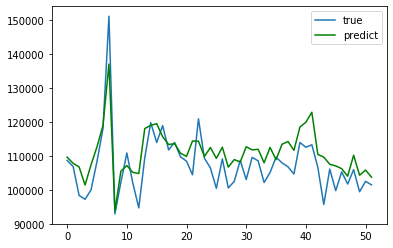

In [42]:
pltx = range(len(gpr_test_x))
plt.figure()
plt.plot(pltx, gpr_test_sales, label='true')
plt.plot(pltx, gpr_predict, c='green', label='predict')
plt.legend(loc='upper right')
plt.show()

### Q3-2.

In [43]:
gpro_train_x = np.array([int(i) for i in train_week])
gpro_train_sales = rf_train.take(1, axis=1)

In [44]:
gpro_train_x = gpro_train_x.reshape(-1, 1)
gpro = GaussianProcessRegressor(kernel=sum_kernel, random_state=0)
gpro.fit(gpro_train_x, gpro_train_sales)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=RBF(length_scale=1) + ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=0)

In [45]:
gpro_test_x = np.array([int(i) for i in test_week])
gpro_test_x = gpro_test_x.reshape(-1, 1)

gpro_predict = gpro.predict(gpro_test_x)

In [46]:
gpro_test_sales = rf_test.take(1, axis=1)
gpro_mape = np.mean(np.abs(gpro_predict - gpro_test_sales) / gpro_test_sales)
print('MAPE of Gaussian Process Regressor with original data = ', gpro_mape)

MAPE of Gaussian Process Regressor with original data =  0.998106655270989


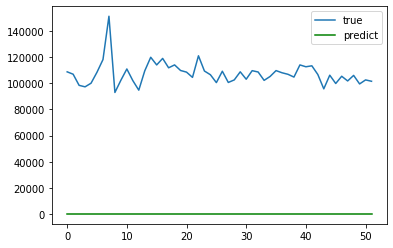

In [47]:
pltx = range(len(gpr_test_x))
plt.figure()
plt.plot(pltx, gpro_test_sales, label='true')
plt.plot(pltx, gpro_predict, c='green', label='predict')
plt.legend(loc='upper right')
plt.show()

### Q3-3.

## Q4. [Summarize and Discuss]

## Q4 [Bonus]

### In this part, I adopt AdaBoostRegressor to develop my model.

In [48]:
from sklearn.ensemble import AdaBoostRegressor

In [49]:
adaboost = AdaBoostRegressor(random_state=0, n_estimators=50, learning_rate=0.01)
adaboost.fit(rf_train_x2, rf_train_y2)

AdaBoostRegressor(base_estimator=None, learning_rate=0.01, loss='linear',
                  n_estimators=50, random_state=0)

In [50]:
adaboost_predict = adaboost.predict(rfr_predict_x2)

In [51]:
adaboost_mape = np.mean(np.abs((adaboost_predict - rfr_true_y) / rfr_true_y))
print('MAPE of AdaBoost with additional same period in last year =', adaboost_mape)

MAPE of AdaBoost with additional same period in last year = 0.035780879996663975


Compared all results in this homework, the one of AdaBoostRegressor is obviously the best one.  
Its value of MAPE is 0.0357808.